<a href="https://colab.research.google.com/github/SNMHZ/Drug_Recommendation/blob/master/DR_Bert_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install datasets

     |████████████████████████████████| 2.6 MB 5.1 MB/s 
     |████████████████████████████████| 3.3 MB 34.5 MB/s 
     |████████████████████████████████| 895 kB 48.2 MB/s 
     |████████████████████████████████| 636 kB 56.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 264 kB 5.0 MB/s 
     |████████████████████████████████| 243 kB 53.0 MB/s 
     |████████████████████████████████| 118 kB 59.2 MB/s 
     |████████████████████████████████| 76 kB 4.3 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [2]:
import random, logging, torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score

from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset, load_metric, ClassLabel, Sequence, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, AdamW

from IPython.display import display, HTML

import re, os
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
PATH = '/content/'

In [4]:
df_train = pd.read_csv("https://raw.githubusercontent.com/SNMHZ/Drug_Recommendation/master/dataset/1/drugsComTrain_raw.csv")
df_train

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
...,...,...,...,...,...,...,...
161292,191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10,31-May-15,125
161293,127085,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1,1-Nov-11,34
161294,187382,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2,15-Mar-14,35
161295,47128,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10,19-Sep-15,79


In [5]:
df_train.isna().sum()

uniqueID         0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [6]:
df_train_drop = df_train.dropna()

In [7]:
df_train_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160398 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     160398 non-null  int64 
 1   drugName     160398 non-null  object
 2   condition    160398 non-null  object
 3   review       160398 non-null  object
 4   rating       160398 non-null  int64 
 5   date         160398 non-null  object
 6   usefulCount  160398 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 9.8+ MB


In [8]:
def clean_text(data):
    p = re.compile(r"[0-9]+[.][0-9]+")
    result = re.sub(p, " NUM", data)
    p = re.compile(r"[a-zA-Z]+[0-9]+")
    result = re.sub(p, " GROUPWITHNUM", result)
    p = re.compile(r'[^0-9ㄱ-힗a-zA-Z%]+')
    result = re.sub(p," ", result)
    p = re.compile(r'[0-9]+')
    result = re.sub(p, " NUM", result)
    p = re.compile(r'[一-龥]+')
    result = re.sub(p, "\g<0> ", result)
    return result

In [9]:
# df_train_drop['review'] = df_train_drop['review'].apply(clean_text)
# df_train_drop['review'][1]

In [10]:
df_train_drop.reset_index(drop=True, inplace=True)

In [11]:
# conditions = []
# reviews = []
# # review split
# for i in range(0, len(df_train_drop)):
#   sentences = re.split('[.!?]', str(df_train_drop.loc[i, 'review']))
#   sentences = list(map(lambda x: x.strip(), sentences))
#   sentences = list(filter(lambda x: x != '', sentences))
# # make list for making new dataframe(this dataframe uses word2vec model)
#   for sentence in sentences:
#     conditions.append(df_train_drop.loc[i, 'condition'])
#     reviews.append(sentence)

In [12]:
#df_train_sentence = pd.DataFrame(data=list(zip(reviews, conditions)), columns=['review', 'condition'])
df_train_sentence = df_train_drop[['review', 'condition']]

In [13]:
df_train_sentence

,review,condition
0,"""It has no side effect, I take it in combinati...",Left Ventricular Dysfunction
1,"""My son is halfway through his fourth week of ...",ADHD
2,"""I used to take another oral contraceptive, wh...",Birth Control
3,"""This is my first time using any form of birth...",Birth Control
4,"""Suboxone has completely turned my life around...",Opiate Dependence
...,...,...
160393,"""I wrote my first report in Mid-October of 201...",Alcohol Dependence
160394,"""I was given this in IV before surgey. I immed...",Nausea/Vomiting
160395,"""Limited improvement after 4 months, developed...",Rheumatoid Arthritis
160396,"""I&#039;ve been on thyroid medication 49 years...",Underactive Thyroid


In [14]:
df_train_sentence['review'] = df_train_sentence['review'].apply(lambda x : x.replace('&#039;', "'"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
df_train_sentence['review'] = df_train_sentence['review'].apply(clean_text)
df_train_sentence.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,review,condition
0,It has no side effect I take it in combinatio...,Left Ventricular Dysfunction
1,My son is halfway through his fourth week of ...,ADHD
2,I used to take another oral contraceptive whi...,Birth Control
3,This is my first time using any form of birth...,Birth Control
4,Suboxone has completely turned my life around...,Opiate Dependence


In [16]:
df_train_sentence[df_train_sentence['condition'].str.contains('</span>')]

,review,condition
104,I m NUM and I have been on Loestrin NUM for...,2</span> users found this comment helpful.
194,I m NUM years old and have always had a pret...,4</span> users found this comment helpful.
241,I took Yaz for a little over NUM years From ...,3</span> users found this comment helpful.
262,Took this pill for NUM Acne and NUM Birth C...,4</span> users found this comment helpful.
389,I have suffered with low back pain NUM surge...,11</span> users found this comment helpful.
...,...,...
159428,Great pill You can definitely see it working ...,99</span> users found this comment helpful.
159893,I am sharing a painful experience actually Th...,62</span> users found this comment helpful.
160000,I ve been taking Geodon for about a month or ...,7</span> users found this comment helpful.
160022,At NUMmg NUMx daily my pain was almost gone,92</span> users found this comment helpful.


In [17]:
df_train_sentence.drop(df_train_sentence[df_train_sentence['condition'].str.contains('</span>')].index, axis=0, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [18]:
df_train_sentence.drop(df_train_sentence.loc[df_train_sentence['review'].apply(lambda x : len(x)) < 5, 'review'].index, axis=0, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [19]:
df_train_sentence

,review,condition
0,It has no side effect I take it in combinatio...,Left Ventricular Dysfunction
1,My son is halfway through his fourth week of ...,ADHD
2,I used to take another oral contraceptive whi...,Birth Control
3,This is my first time using any form of birth...,Birth Control
4,Suboxone has completely turned my life around...,Opiate Dependence
...,...,...
160393,I wrote my first report in Mid October of NU...,Alcohol Dependence
160394,I was given this in IV before surgey I immedi...,Nausea/Vomiting
160395,Limited improvement after NUM months develop...,Rheumatoid Arthritis
160396,I ve been on thyroid medication NUM years I ...,Underactive Thyroid


Text(0, 0.5, 'count')

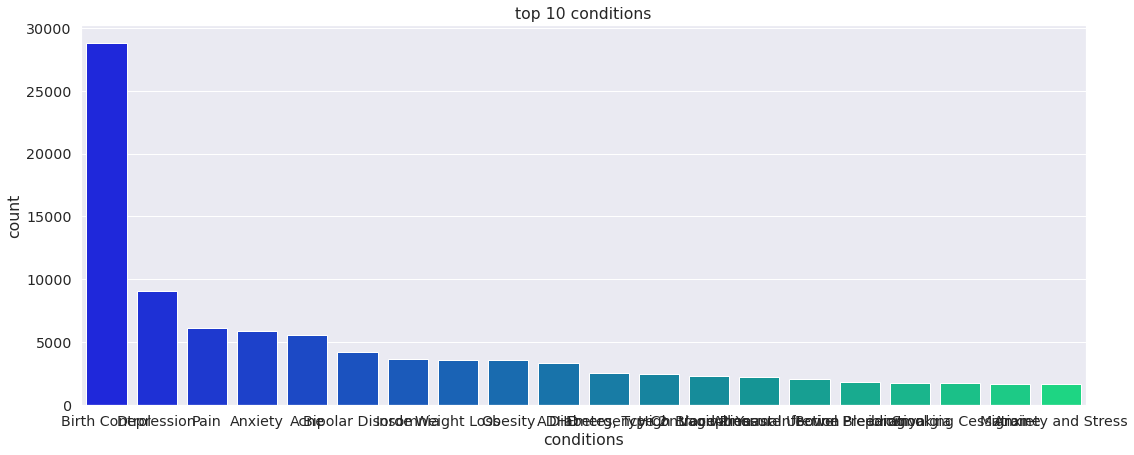

In [20]:
cond = dict(df_train_sentence['condition'].value_counts())
top_condition = list(cond.keys())[0:20]
values = list(cond.values())[0:20]
sns.set(style= 'darkgrid', font_scale= 1.3)
plt.rcParams['figure.figsize'] = [18,7]

sns_ = sns.barplot(x=top_condition, y=values, palette='winter')
sns_.set_title('top 10 conditions')
sns_.set_xlabel('conditions')
sns_.set_ylabel('count')

In [21]:
df_train_sentence['condition'].value_counts()

Birth Control           28788
Depression               9069
Pain                     6144
Anxiety                  5903
Acne                     5588
                        ...  
Sepsis                      1
acial Lipoatrophy           1
Hydrocephalus               1
Cyclitis                    1
Tuberculosis, Active        1
Name: condition, Length: 810, dtype: int64

In [22]:
top_df = df_train_sentence.loc[df_train_sentence['condition'].apply(lambda x : x in top_condition)]

In [23]:
top_df.reset_index(drop=True, inplace=True)
top_df

,review,condition
0,My son is halfway through his fourth week of ...,ADHD
1,I used to take another oral contraceptive whi...,Birth Control
2,This is my first time using any form of birth...,Birth Control
3,He pulled out but he cummed a bit in me I too...,Emergency Contraception
4,Abilify changed my life There is hope I was o...,Bipolar Disorde
...,...,...
94439,I was in a very bad place at the time I start...,Bipolar Disorde
94440,This is the third med I ve tried for anxiety ...,Depression
94441,I was super against taking medication I ve st...,Anxiety
94442,I have only been on Tekturna for NUM days Th...,High Blood Pressure


In [24]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
top_df['label'] = encoder.fit_transform(top_df['condition'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
top_df

,review,condition,label
0,My son is halfway through his fourth week of ...,ADHD,0
1,I used to take another oral contraceptive whi...,Birth Control,6
2,This is my first time using any form of birth...,Birth Control,6
3,He pulled out but he cummed a bit in me I too...,Emergency Contraception,10
4,Abilify changed my life There is hope I was o...,Bipolar Disorde,5
...,...,...,...
94439,I was in a very bad place at the time I start...,Bipolar Disorde,5
94440,This is the third med I ve tried for anxiety ...,Depression,8
94441,I was super against taking medication I ve st...,Anxiety,3
94442,I have only been on Tekturna for NUM days Th...,High Blood Pressure,11


In [26]:
max(top_df['label'])

19

In [71]:
def preprocess_function(examples):
    return tokenizer(
        examples[sentence1_key],
        truncation=True,
        padding=True,
        max_length=184,
        return_token_type_ids=False,
    )

In [28]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels, average='macro')

In [29]:
from sklearn.model_selection import train_test_split
train_data2, validation_data = train_test_split(top_df, test_size=0.2, random_state=1)

In [30]:
train_data2.to_csv(PATH + "train_dataset.csv", index=False)
validation_data.to_csv(PATH + "validation_dataset.csv", index=False)

In [31]:
dataset = load_dataset('csv', data_files={'train': PATH + "train_dataset.csv", "validation":PATH + "validation_dataset.csv"})
#test_dataset = load_dataset('csv', data_files={'test': PATH + "test_data.csv"})

Using custom data configuration default-1952191b08687ced


0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-1952191b08687ced/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff. Subsequent calls will reuse this data.


In [72]:
model_checkpoint = 'google/bert_uncased_L-12_H-512_A-8'
batch_size = 64
task = "tc"

In [33]:
metric = load_metric("f1")

Downloading:   0%|          | 0.00/1.96k [00:00<?, ?B/s]

In [34]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

Downloading:   0%|          | 0.00/384 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [35]:
sentence1_key = "review"
print(f"Sentence 1: {dataset['train'][0][sentence1_key]}")

Sentence 1:  Took My Way  NUM hours after having unprotected sex He actually came inside me with no condom on My period was  NUM days late No pain before period came or after taking the pill Cramps are more intense than usual during period but other than that no side effects This pill works 


In [73]:
encoded_datasets = dataset.map(preprocess_function, batched=True)
#test_encoded_datasets = test_dataset.map(preprocess_function, batched=True)
encoded_datasets

  0%|          | 0/76 [00:00<?, ?ba/s]

  0%|          | 0/19 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'condition', 'input_ids', 'label', 'review'],
        num_rows: 75555
    })
    validation: Dataset({
        features: ['attention_mask', 'condition', 'input_ids', 'label', 'review'],
        num_rows: 18889
    })
})

In [37]:
len(encoded_datasets['train']['attention_mask'][1])

500

In [70]:
# #length = [len(x) for x in encoded_datasets['train']['attention_mask']]
# for l in range(150,200):
#     print("Length under {} \t Percentage : {}".format(l, (df_length[df_length['length']< l].shape[0])/ (df_length.shape[0]) ))
# # length[length<20]

Length under 150 	 Percentage : 0.7501290450665078
Length under 151 	 Percentage : 0.7588511680232943
Length under 152 	 Percentage : 0.7683938852491562
Length under 153 	 Percentage : 0.7782807226523725
Length under 154 	 Percentage : 0.7888558004102971
Length under 155 	 Percentage : 0.7989941102508107
Length under 156 	 Percentage : 0.8104824300178678
Length under 157 	 Percentage : 0.8207927999470584
Length under 158 	 Percentage : 0.8313546423135464
Length under 159 	 Percentage : 0.8417841307656674
Length under 160 	 Percentage : 0.8531665674012309
Length under 161 	 Percentage : 0.8638342928992125
Length under 162 	 Percentage : 0.8750976110118457
Length under 163 	 Percentage : 0.8860300443385614
Length under 164 	 Percentage : 0.8964992389649924
Length under 165 	 Percentage : 0.9056846006220634
Length under 166 	 Percentage : 0.9139831910528754
Length under 167 	 Percentage : 0.9220832506121368
Length under 168 	 Percentage : 0.9300509562570313
Length under 169 	 Percentage :

In [62]:
# df_length = pd.DataFrame(length, columns=['length'])

In [74]:
num_labels = 20
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

loading configuration file https://huggingface.co/google/bert_uncased_L-12_H-512_A-8/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/62bdb8940aeadcccb844d1cba3cc22706a1e41fa1f7a0c5deb6eff1ae4fd92f0.dfafa4bccbbd2c8139c5d7b863145b1f49186fb7f0a91e54657e9496c994eeb4
Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19"
  },
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "label2id": {
    "LABEL_0": 0,


In [75]:
metric_name = "eval_loss"

args = TrainingArguments(
    "test-ynat",
    evaluation_strategy="steps",
    learning_rate=3e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
)

using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [76]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_datasets["train"],
    eval_dataset=encoded_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [77]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: review, condition.
***** Running training *****
  Num examples = 75555
  Num Epochs = 2
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 2362


Step,Training Loss,Validation Loss,F1
500,1.184700,0.663190,0.715316
1000,0.604600,0.520742,0.779052
1500,0.492800,0.475694,0.807719
2000,0.432600,0.450248,0.815626


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: review, condition.
***** Running Evaluation *****
  Num examples = 18889
  Batch size = 64
Saving model checkpoint to test-ynat/checkpoint-500
Configuration saved in test-ynat/checkpoint-500/config.json
Model weights saved in test-ynat/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test-ynat/checkpoint-500/tokenizer_config.json
Special tokens file saved in test-ynat/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: review, condition.
***** Running Evaluation *****
  Num examples = 18889
  Batch size = 64
Saving model checkpoint to test-ynat/checkpoint-1000
Configuration saved in test-ynat/checkpoint-1000/config.json
Model weights saved in test-ynat/checkpoint-1000/pytorch_model.bin
tokenizer

TrainOutput(global_step=2362, training_loss=0.6377592740878526, metrics={'train_runtime': 1598.5146, 'train_samples_per_second': 94.532, 'train_steps_per_second': 1.478, 'total_flos': 6356474335221120.0, 'train_loss': 0.6377592740878526, 'epoch': 2.0})

In [78]:
df_test = pd.read_csv("https://raw.githubusercontent.com/SNMHZ/Drug_Recommendation/master/dataset/1/drugsComTest_raw.csv")
df_test_drop = df_test.dropna()
df_test_drop.reset_index(drop=True, inplace=True)
df_test_sentence = df_test_drop[['review', 'condition']]
df_test_sentence['review'] = df_test_sentence['review'].apply(lambda x : x.replace('&#039;', "'"))
df_test_sentence['review'] = df_test_sentence['review'].apply(clean_text)
df_test_sentence[df_test_sentence['condition'].str.contains('</span>')]
df_test_sentence.drop(df_test_sentence[df_test_sentence['condition'].str.contains('</span>')].index, axis=0, inplace=True)
df_test_sentence.drop(df_test_sentence.loc[df_test_sentence['review'].apply(lambda x : len(x)) < 5, 'review'].index, axis=0, inplace=True)
top_df_test = df_test_sentence.loc[df_test_sentence['condition'].apply(lambda x : x in top_condition)]
top_df_test.reset_index(drop=True, inplace=True)
top_df_test['label'] = encoder.fit_transform(top_df_test['condition'])
test_dataset = Dataset.from_pandas(top_df_test)
test_encoded_datasets = test_dataset.map(preprocess_function, batched=True)
output = trainer.predict(test_encoded_datasets)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

  0%|          | 0/32 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: review, condition.
***** Running Prediction *****
  Num examples = 31681
  Batch size = 64


In [79]:
topic = []
for i in range(len(output[0])):
    topic.append(np.argmax(output[0][i]))

In [81]:

from sklearn.metrics import confusion_matrix, f1_score
cf = confusion_matrix(test_encoded_datasets['label'], topic)
print(cf)

[[1004    0    1   13    0   13    6    2   44    5    0    2   15    4
     5    7    1    1    0    3]
 [   0  252    5    0    0    0  383    0    2    0    3    1    0    0
     0    1    0    0    0    1]
 [   4    0 1701    1    0    0  108    0    8    1    1    6    3    0
     1   10    0    3    0    0]
 [  15    0    1 1432   20   27    5    0  290    3    2   16   40    2
     2   47    2    2    0    2]
 [   9    0    0  131  177   11    2    0  214    1    0    3    9    1
     4    8    1    0    0    2]
 [  20    0    0   53    1 1062   10    0  179    3    1   10   25    0
     1    7    0    0    7    1]
 [   1   86   95    1    1    5 9387    0   21    3    4    8    3    0
    10   15    0    3    3    2]
 [   0    0    0    0    0    0    1  623    0    4    1    1    3    0
     2    4    0    0    0    0]
 [  26    0    3  199   52  150   19    1 2523   10    2   11   40    3
     9   32    2    0    0   13]
 [   0    0    0    2    0    1    7    1   13  709    

In [82]:
f1 = f1_score(test_encoded_datasets['label'], topic, average='macro')
f1

0.8119580396137055